# k-Nearest Neighbours Lab: Palmer Penguins Classification

In this lab, you will:
1. Load and explore the Palmer Penguins dataset
2. Understand the importance of feature scaling for kNN
3. Use cross-validation to tune hyperparameters
4. Compare kNN and Logistic Regression
5. Evaluate your final model on a held-out test set

**Dataset:** The Palmer Penguins dataset contains measurements of penguins from three species (Adelie, Chinstrap, Gentoo) collected from islands in Antarctica.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Data

Load the `penguins.csv` file and examine the dataset.

In [2]:
# Load the dataset
# Your code here
df = pd.read_csv('penguins.csv')

# Display the first few rows
# Your code here
(df.head())

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [3]:
# Check the shape and info about the dataset
# Your code here
print(df.shape)
print(df.info())

(344, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB
None


In [4]:
# Check for missing values
# Print all null values
df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

## 3. Data Preprocessing

We'll use the numerical features: bill_length_mm, bill_depth_mm, flipper_length_mm, and body_mass_g.

**Note the different scales:**
- Bill measurements are in millimeters (~30-60 mm)
- Flipper length is in millimeters (~170-230 mm)
- Body mass is in grams (~2700-6300 g)

These different scales will affect kNN!

In [5]:
# Drop rows with missing values
# Your code here
df_clean = df.dropna(subset=['species', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])

# Select features and target
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = df_clean[feature_columns]
y = df_clean['species']

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {y.nunique()}")
print(f"Class distribution:\n{y.value_counts()}")

Dataset shape: (342, 4)
Number of classes: 3
Class distribution:
species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64


In [6]:
# Look at the feature ranges - notice how different they are!
# Your code here
X.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


## 4. Train-Test Split

Split the data into training (80%) and test (20%) sets. 
We'll use the training set for cross-validation and hyperparameter tuning, 
and keep the test set completely separate for final evaluation.

In [7]:
# Split the data
# Your code here - use test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 273
Test set size: 69


## 5. Introduction to Cross-Validation

Before we start building models, let's understand **cross-validation**.

**Why cross-validation?**
- Using a single train-test split can be unreliable (results depend on which samples end up in each set)
- Cross-validation splits the training data into K "folds" and evaluates the model K times
- Each fold gets a turn being the validation set while the others are used for training
- We get K accuracy scores and can compute the mean and standard deviation

**We'll use `cross_val_score`:**
```python
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
```

This performs 5-fold cross-validation and returns 5 accuracy scores (one per fold).

## 6. kNN Without Scaling

First, let's try kNN without scaling to see what happens.
We'll use cross-validation to evaluate performance.

In [8]:
# Create a kNN classifier with k=5
# Your code here
knn_unscaled = KNeighborsClassifier(n_neighbors=5)

# Use 5-fold cross-validation to evaluate on the training set
# Your code here - use cv=5
scores_unscaled = cross_val_score(knn_unscaled, X_train, y_train, cv=5)

print(f"Cross-validation scores (unscaled): {scores_unscaled}")
print(f"Mean CV accuracy (unscaled): {scores_unscaled.mean():.3f} (+/- {scores_unscaled.std():.3f})")

Cross-validation scores (unscaled): [0.85454545 0.76363636 0.78181818 0.7037037  0.77777778]
Mean CV accuracy (unscaled): 0.776 (+/- 0.048)


## 7. kNN With Scaling (using Pipeline)

Now let's scale the features using StandardScaler and see if performance improves.

**Using Pipeline:**
We'll use `make_pipeline` to combine the scaler and classifier. This is best practice because:
- It ensures scaling is applied consistently
- When used with cross-validation, it scales each fold independently (preventing data leakage)
- It's cleaner and less error-prone than manual scaling

In [9]:
# Create a pipeline that scales then applies kNN
# Your code here - use make_pipeline with StandardScaler() and KNeighborsClassifier(n_neighbors=5)
knn_pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))

# Use cross-validation to evaluate
# Your code here
scores_scaled = cross_val_score(knn_pipeline, X_train, y_train, cv=5)

print(f"Cross-validation scores (scaled): {scores_scaled}")
print(f"Mean CV accuracy (scaled): {scores_scaled.mean():.3f} (+/- {scores_scaled.std():.3f})")

Cross-validation scores (scaled): [1.         1.         1.         0.96296296 0.98148148]
Mean CV accuracy (scaled): 0.989 (+/- 0.015)


In [10]:
# Compare the results
print("\n=== Comparison ===")
print(f"Unscaled kNN: {scores_unscaled.mean():.3f} (+/- {scores_unscaled.std():.3f})")
print(f"Scaled kNN:   {scores_scaled.mean():.3f} (+/- {scores_scaled.std():.3f})")
print(f"Improvement:  {(scores_scaled.mean() - scores_unscaled.mean()):.3f}")


=== Comparison ===
Unscaled kNN: 0.776 (+/- 0.048)
Scaled kNN:   0.989 (+/- 0.015)
Improvement:  0.213


### Question: Why does scaling help kNN?

*Write your answer here:* Because values that are "bigger" (even though they're not actually bigger) may create a unbalanced prediction.



### Question: Why is using a Pipeline better than manually scaling?

*Write your answer here (hint: think about cross-validation and data leakage):* a pipeline chains the scaler and the kNN model so they happen before fitting and predicting, which ensures that the process is clean.


## 8. Hyperparameter Tuning with Cross-Validation

Now let's find the best value of k using cross-validation.
We'll test k values from 1 to 20.

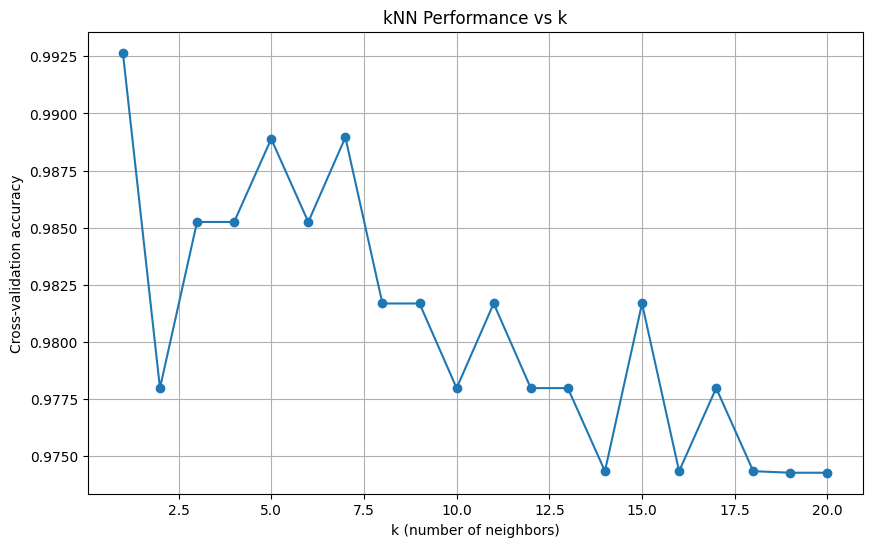


Best k: 1
Best CV accuracy: 0.993


In [11]:
# Test different values of k
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    # Your code here - create a pipeline with StandardScaler and KNeighborsClassifier with this k value
    pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=k))
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5) # cv=5 is the default value
    cv_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Cross-validation accuracy')
plt.title('kNN Performance vs k')
plt.grid(True)
plt.show()

# Find the best k
best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)
print(f"\nBest k: {best_k}")
print(f"Best CV accuracy: {best_score:.3f}")

### Alternative: Using GridSearchCV

GridSearchCV is a convenient way to do hyperparameter tuning with cross-validation.
When using it with a pipeline, we need to specify which step's parameters we're tuning.

In [12]:
# Create a pipeline
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Define the parameter grid - note the syntax for pipeline parameters
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 21)}

# Create GridSearchCV object
# Your code here - use cv=5
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit on training data (pipeline handles scaling automatically)
# Your code here
grid_search.fit(X_train, y_train)

print(f"Best k from GridSearchCV: {grid_search.best_params_['kneighborsclassifier__n_neighbors']}")
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")

Best k from GridSearchCV: 1
Best CV accuracy: 0.993


## 9. Logistic Regression

Now let's try Logistic Regression and compare it to kNN.
We'll also tune its hyperparameter (C, the regularization strength) using cross-validation.

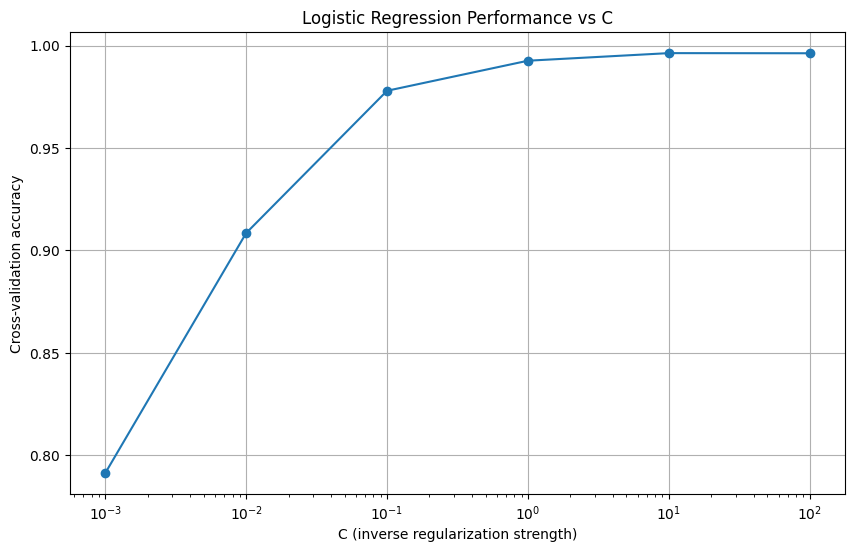


Best C: 10
Best CV accuracy: 0.996


In [13]:
# Test different C values for Logistic Regression
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
lr_scores = []

for C in C_values:
    # Your code here - create a pipeline with StandardScaler and LogisticRegression
    # Use max_iter=1000 to ensure convergence
    pipeline = make_pipeline(StandardScaler(), LogisticRegression(C=C, max_iter=1000))
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    lr_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, lr_scores, marker='o')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Cross-validation accuracy')
plt.title('Logistic Regression Performance vs C')
plt.grid(True)
plt.show()

# Find the best C
best_C = C_values[np.argmax(lr_scores)]
best_lr_score = max(lr_scores)
print(f"\nBest C: {best_C}")
print(f"Best CV accuracy: {best_lr_score:.3f}")

## 10. Model Comparison and Selection

Compare the best kNN model with the best Logistic Regression model using cross-validation.

In [14]:
# Create final models (pipelines) with best hyperparameters
# Your code here
final_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=best_k))
final_lr = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, max_iter=1000))

# Evaluate both with cross-validation
# Your code here
knn_cv_scores = cross_val_score(final_knn, X_train, y_train, cv=5)
lr_cv_scores = cross_val_score(final_lr, X_train, y_train, cv=5)

print("=== Final Model Comparison (Cross-Validation) ===")
print(f"kNN (k={best_k}):              {knn_cv_scores.mean():.3f} (+/- {knn_cv_scores.std():.3f})")
print(f"Logistic Regression (C={best_C}): {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std():.3f})")

=== Final Model Comparison (Cross-Validation) ===
kNN (k=1):              0.993 (+/- 0.009)
Logistic Regression (C=10): 0.996 (+/- 0.007)


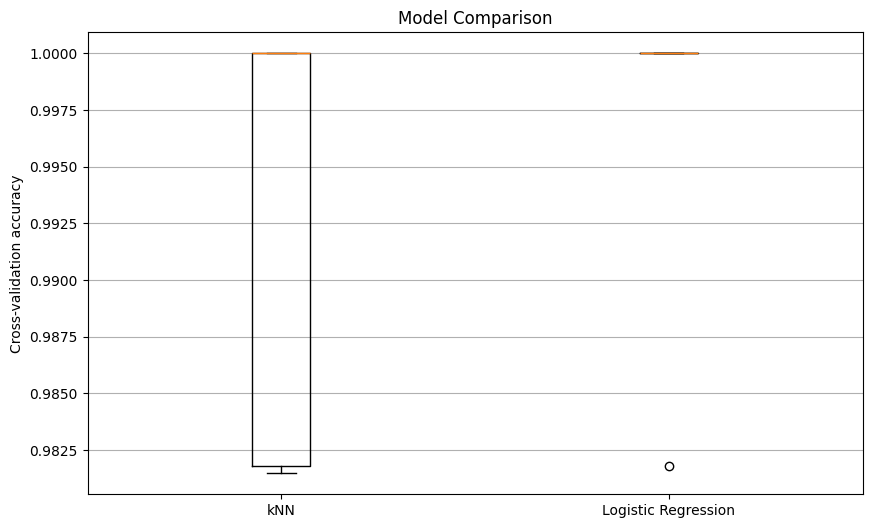

In [17]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.boxplot([knn_cv_scores, lr_cv_scores], tick_labels=['kNN', 'Logistic Regression'])
plt.ylabel('Cross-validation accuracy')
plt.title('Model Comparison')
plt.grid(True, axis='y')
plt.show()

### Question: Which model would you choose and why?

*Write your answer here, considering both performance and other factors (interpretability, training time, etc.):* LR model with C=10 is more accurate...



## 11. Final Evaluation on Test Set

Now that we've selected our best model using cross-validation, 
let's evaluate it on the held-out test set to get an unbiased estimate of performance.

In [22]:
# Choose your final model (uncomment one)
#final_model = final_knn
final_model = final_lr

# Train on the full training set
# Your code here
final_model.fit(X_train, y_train)

# Predict on test set
# Your code here
y_pred = final_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.3f}")

Test Set Accuracy: 0.986


In [20]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        35
   Chinstrap       0.92      1.00      0.96        11
      Gentoo       1.00      1.00      1.00        23

    accuracy                           0.99        69
   macro avg       0.97      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69



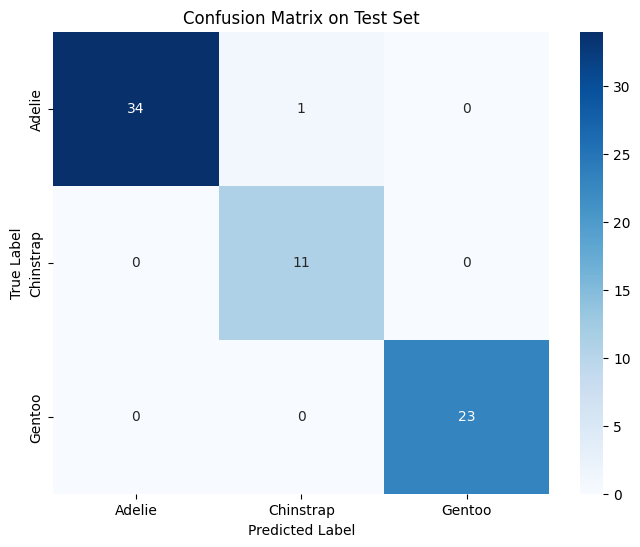

In [23]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_model.classes_, 
            yticklabels=final_model.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

## 12. Reflection Questions

1. **Why is feature scaling important for kNN but not for Logistic Regression?**

*Your answer:* kNN is distance-based whereas LR is more weight-based, so we need to scale the features to ensure that the prediction isn't wrong due to some features having large values.

2. **Why do we need a separate test set? Why can't we just use cross-validation scores?**

*Your answer:* Test set is separate because the 


3. **What happens if k is too small (e.g., k=1)? What if k is too large?**

*Your answer:*


4. **How would you explain the w^T x + b connection between Logistic Regression and the models you'll learn next?**

*Your answer:*

## Bonus 1: Adding Categorical Features (Optional)

So far we've only used numerical features. The dataset also has categorical features:
- `island`: Biscoe, Dream, or Torgersen
- `sex`: male or female

Let's see if adding these improves our model performance!

In [ ]:
# Reload the data and keep categorical columns
df_with_cat = pd.read_csv('penguins.csv')

# Drop rows with missing values
df_with_cat = df_with_cat.dropna()

# Look at the categorical columns
print("Island distribution:")
print(df_with_cat['island'].value_counts())
print("\nSex distribution:")
print(df_with_cat['sex'].value_counts())

### One-Hot Encoding

We need to convert categorical variables to numerical format. 
We'll use one-hot encoding, which creates a binary column for each category.

In [ ]:
# Create feature matrix with both numerical and categorical features
# We'll use pd.get_dummies() for one-hot encoding
# Your code here
X_with_cat = df_with_cat[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island', 'sex']]
X_encoded = 

y_with_cat = df_with_cat['species']

print(f"Original features: {X_with_cat.shape[1]}")
print(f"After one-hot encoding: {X_encoded.shape[1]}")
print(f"\nNew feature names: {list(X_encoded.columns)}")

In [ ]:
# Split the data
# Your code here
X_train_cat, X_test_cat, y_train_cat, y_test_cat = 

# Scale the features (important - one-hot encoded features are already 0/1, 
# but we still scale everything for consistency)
# Your code here
scaler_cat = 
X_train_cat_scaled = 
X_test_cat_scaled = 

In [ ]:
# Try kNN with the expanded feature set
# Use the best k we found earlier (or tune again if you want)
# Your code here
knn_with_cat = 
scores_with_cat = 

print(f"kNN with categorical features: {scores_with_cat.mean():.3f} (+/- {scores_with_cat.std():.3f})")
print(f"kNN with only numerical features: {knn_cv_scores.mean():.3f} (+/- {knn_cv_scores.std():.3f})")
print(f"\nImprovement: {(scores_with_cat.mean() - knn_cv_scores.mean()):.3f}")

In [ ]:
# Also try Logistic Regression
# Your code here
lr_with_cat = 
scores_lr_cat = 

print(f"Logistic Regression with categorical features: {scores_lr_cat.mean():.3f} (+/- {scores_lr_cat.std():.3f})")
print(f"Logistic Regression with only numerical features: {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std():.3f})")
print(f"\nImprovement: {(scores_lr_cat.mean() - lr_cv_scores.mean()):.3f}")

### Question: Did adding categorical features improve performance? Why or why not?

*Your answer:*



## Bonus 2: Feature Importance (Optional)

Logistic Regression gives us interpretable coefficients. Let's see which features are most important.

In [ ]:
# If you chose Logistic Regression, visualize feature importance
if isinstance(final_model, LogisticRegression):
    # For multi-class, we have one coefficient per class
    coefficients = final_model.coef_
    
    plt.figure(figsize=(10, 6))
    for i, species in enumerate(final_model.classes_):
        plt.barh(range(len(feature_columns)), coefficients[i], 
                alpha=0.7, label=species)
    plt.yticks(range(len(feature_columns)), feature_columns)
    plt.xlabel('Coefficient Value')
    plt.title('Feature Importance by Species')
    plt.legend()
    plt.grid(True, axis='x')
    plt.show()
else:
    print("Feature importance is not directly available for kNN.")
    print("This is one advantage of Logistic Regression - interpretability!")

In [ ]:
# If you did the categorical features bonus, you can visualize those coefficients too
# Your code here (optional)
